In [114]:
import numpy as np
import time
import pickle
import utils as Utils
import pandas as pd
import random
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
# import modules.model as Model
from matplotlib.backends.backend_pdf import PdfPages
import sklearn.metrics as metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score,classification_report,roc_curve,auc, f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE 
# import modules.processor as Processor
# import modules.utils as Utils
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from tqdm import tqdm
import processor as Processor

In [115]:
train_data = pd.read_csv("../../Final_data/preprocessed/filtered/split_data_without_mhc/test/train.csv")
train_data_1 = train_data[train_data.binder == 1]
train_data_0 = train_data[train_data.binder == 0]

In [116]:
len(train_data_1.epitope.unique())

487

In [117]:
train_data_1

,CDR3b,epitope,binder
0,ASSPQGHEQYV,KLGGALQAK,1
1,ASFVTGNPNTEAF,KLSYGIATV,1
2,ASSLAPGLGHNEQF,LVVDFSQFSR,1
3,ASCAQMEQF,YVLDHLIVV,1
4,ASRPFLDRGDYGYT,AVFDRKSDAK,1
...,...,...,...
6679,ASSFTDGDNEQF,KLGGALQAK,1
6680,ASRDTSYEQYV,KLGGALQAK,1
6681,ASSLSWDRFNTEAF,KLNVGDYFV,1
6682,ASRPGLAGEEY,KLSYGIATV,1


In [118]:
len(train_data_0.epitope.unique())

50

In [119]:
def check_length_full(df):
    df["len_epitope"] = df.epitope.str.len()
    df = df[(df["len_epitope"] <= 11) & (df["len_epitope"] >= 8)]
    df["len_cdr3"] = df.CDR3b.str.len()
    df = df[(df["len_cdr3"] <= 19) & (df["len_cdr3"] >= 8)]
    df = df.drop(['len_epitope', 'len_cdr3'], axis=1)
    df = df.reset_index(drop=True)
    
    discard = ["\*", '_', '-', 'O', '1', 'y', 'l', 'X', '/', ' ']
    df = df[~df.CDR3b.str.contains('|'.join(discard))]
    df = df[~df.epitope.str.contains('|'.join(discard))]
    return df

In [120]:
result = pd.read_csv("./process_data/data/process/result.csv")
result = result.sample(n=900000, random_state=123).reset_index(drop=True)
result = check_length_full(result)

list_epitope = result.epitope.unique()
sample_list = random.choices(list_epitope, k=490)

result = check_length_full(result[result.epitope.isin(sample_list)]).reset_index(drop=True)
result

<ipython-input-119-2b0faeea28aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["len_epitope"] = df.epitope.str.len()


,epitope,CDR3b,binder
0,FLLGNLSFL,ATTGGSGYEQY,0
1,LLLAHIIAL,ASSPPNSYEQY,0
2,ILGIFNEFV,ASSYSVAPEQF,0
3,SLDKFLASV,AWSSRDSMTDTQY,0
4,IQIFTIVLVSY,ASSPYGGNTDTQY,0
...,...,...,...
159638,YLYESGETEKL,ASNPLLGAGGTYNEQF,0
159639,IMACVGFFL,ATGKTSGLTGAGELF,0
159640,SVYDFFVWL,AISGGSGDNEQ,0
159641,IMIGVLVGVA,SATRRDRGLEQY,0


In [121]:
len(result.epitope.unique())

444

In [122]:
train_final = pd.concat([train_data, result]).reset_index(drop=True)
train_final

,CDR3b,epitope,binder
0,ASSPQGHEQYV,KLGGALQAK,1
1,ASFVTGNPNTEAF,KLSYGIATV,1
2,ASSLAPGLGHNEQF,LVVDFSQFSR,1
3,ASCAQMEQF,YVLDHLIVV,1
4,ASRPFLDRGDYGYT,AVFDRKSDAK,1
...,...,...,...
481003,ASNPLLGAGGTYNEQF,YLYESGETEKL,0
481004,ATGKTSGLTGAGELF,IMACVGFFL,0
481005,AISGGSGDNEQ,SVYDFFVWL,0
481006,SATRRDRGLEQY,IMIGVLVGVA,0


In [123]:
len(train_final.epitope.unique())

949

In [124]:
train_final.binder.value_counts()

0    474324
1      6684
Name: binder, dtype: int64

In [125]:
print(len(train_final[train_final.binder == 1].epitope.unique()))
print(len(train_final[train_final.binder == 0].epitope.unique()))

487
494


In [126]:
X_train = train_final[["CDR3b", "epitope"]]
y_train = train_final[["binder"]]

In [127]:
nm = RandomUnderSampler(random_state=42)
X_res, y_res = nm.fit_resample(X_train, y_train)

In [128]:
train_data_epi = train_final.epitope.unique()
print(len(train_data_epi))

949


In [129]:
test_cb_26 = pd.read_csv("../../Improve_model/combine_model/data_test/pmtnet_v2.csv")
test_cb_26_1 = pd.read_csv("../../Improve_model/combine_model/data_test/pmtnet_paper1_v2.csv")
test_cb_26 = test_cb_26[test_cb_26["binder"] == 0]
test_cb_26 = test_cb_26.reset_index(drop=True)
ptest_cb_26  = pd.concat([test_cb_26, test_cb_26_1], axis=0)
ptest_cb_26 = ptest_cb_26[~ptest_cb_26.epitope.isin(train_data_epi)]
ptest_cb_26  = ptest_cb_26.reset_index(drop=True)
ptest_cb_26  = check_length_full(ptest_cb_26)
ptest_cb_26

<ipython-input-119-2b0faeea28aa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["len_cdr3"] = df.CDR3b.str.len()


,CDR3b,epitope,binder
0,ASRPGQVVYGYT,FLTVFSHFM,0
1,ASRPGQVVYGYT,ALIHHNTYL,0
2,ASRPGQVVYGYT,ILIVMFPFL,0
3,ASRPGQVVYGYT,LLAGTLAVV,0
4,ASRPGQVVYGYT,LLAILTYYV,0
...,...,...,...
15447,SAHRAGTSGADYNEQF,SLLWMNLFV,1
15448,ASSIRVSGANVLT,SLLWMNLFV,1
15449,ASSYGGSSYEQY,SLLWMNLFV,1
15450,ATSFSRMANEKLF,SLLWMNLFV,1


In [130]:
test_final.binder.value_counts()

0    15140
1      286
Name: binder, dtype: int64

In [131]:
len(test_final.epitope.unique())

104

In [132]:
train_final.to_csv("../../Tools/NetTCR-2.0/test/train_final.csv", index=False)
test_final.to_csv("../../Tools/NetTCR-2.0/test/test_final.csv", index=False)

In [133]:
test_final = ptest_cb_26.copy()

X_test = test_final[["CDR3b", "epitope"]]
y_test = test_final[["binder"]]

In [134]:
pX_res = Processor.data_representation_blosum62(X_res)
py_res = y_res.copy()

pX_test = Processor.data_representation_blosum62(X_test)
py_test = y_test.copy()

In [135]:
pX_res

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,-1.0,1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13363,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13364,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13365,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13366,4.0,-1.0,-2.0,-2.0,0.0,-1.0,-1.0,0.0,-2.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
lst_models = [
    ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1)),
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [137]:
def train(lst_models, X, y, cv):
    res_table = []
    for mdl_name, model in tqdm(lst_models):
        tic = time.time()
        cv_res = cross_validate(model, X, y, cv=cv, return_train_score=True, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
        res_table.append([mdl_name, 
                          cv_res['train_accuracy'].mean(), 
                          cv_res['test_accuracy'].mean(), 
                          np.abs(cv_res['train_accuracy'].mean() - cv_res['test_accuracy'].mean()),
                          cv_res['train_accuracy'].std(),
                          cv_res['test_accuracy'].std(),
                          cv_res['train_roc_auc'].mean(),
                          cv_res['test_roc_auc'].mean(),
                          np.abs(cv_res['train_roc_auc'].mean() - cv_res['test_roc_auc'].mean()),
                          cv_res['train_roc_auc'].std(),
                          cv_res['test_roc_auc'].std(),
                          cv_res['fit_time'].mean()
        ])
        toc = time.time()
        print('\tModel {} has been trained in {:,.2f} seconds'.format(mdl_name, (toc - tic)))
    
    res_table = pd.DataFrame(res_table, columns=['model', 'train_acc', 'test_acc', 'diff_acc',
                                                 'train_acc_std', 'test_acc_std', 'train_roc_auc', 'test_roc_auc',
                                                 'diff_roc_auc', 'train_roc_auc_std', 'test_roc_auc_std', 'fit_time'])
    res_table.sort_values(by=['test_acc', 'test_roc_auc'], ascending=False, inplace=True)

    return res_table.reset_index(drop=True)

In [74]:
original_models = train(lst_models, pX_res, np.ravel(py_res), cv)
original_models

100%|██████████| 1/1 [00:07<00:00,  7.24s/it]

	Model Random Forest has been trained in 7.24 seconds


,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,Random Forest,1.0,0.924596,0.075404,0.0,0.003407,1.0,0.977139,0.022861,0.0,0.001348,0.887525


In [99]:
lst_tunning_models = [
     ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1), {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ["auto", "sqrt", "log2", 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4],
        'n_estimators': [200, 400, 600, 800, 1000]})]

def trainTunningModel(lst_models, X, y, cv):
    models_final = []
    for model_name, model, params in tqdm(lst_models):
        tic     = time.time()
        search = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1)
        search.fit(X, y)
        model_tunned = model.set_params(**search.best_params_)
        models_final.append((model_name, model_tunned))
        toc = time.time()
        print('Model {} has been tunned in {:,.2f} seconds'.format(model_name, (toc - tic)))

    return models_final

In [100]:
lst_tunning_models = trainTunningModel(lst_tunning_models, pX_res, np.ravel(py_res), cv)
lst_tunning_models

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 1/1 [1:15:58<00:00, 4558.79s/it]

Model Random Forest has been tunned in 4,558.74 seconds


[('Random Forest',
  RandomForestClassifier(bootstrap=False, max_depth=20, max_features='auto',
                         n_estimators=200, n_jobs=-1, random_state=42))]

In [ ]:
# tunning_models = train(lst_tunning_models, pX_res, np.ravel(py_res), cv)
# tunning_models

In [76]:
def evaluation(tunning_models, X_train, y_train, X_test, y_test):
    res = []
    for name, model in tqdm(tunning_models):
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_roc_auc = roc_auc_score(y_train, y_train_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_pred)
        res.append([name, train_acc, test_acc, train_roc_auc, test_roc_auc])
        
    res = pd.DataFrame(res, columns=['model', 'train_acc', 'test_acc', 'train_roc_auc', 'test_roc_auc'])
    res.sort_values(by=['test_acc', 'test_roc_auc'], ascending=False, inplace=True)
    
    return res.reset_index(drop=True)

In [138]:
lst_tunning_models = [('Random Forest', RandomForestClassifier(bootstrap=False, max_depth=20, max_features='auto',
                         n_estimators=200, n_jobs=-1, random_state=42))]

# lst_tunning_models2 = [('Random Forest', 
# RandomForestClassifier(bootstrap=False, max_depth=70, max_features=5, n_estimators=200, n_jobs=-1, random_state=42))]

In [139]:
best_models = evaluation(lst_tunning_models, pX_res, np.ravel(py_res), pX_test, py_test)
best_models

100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


,model,train_acc,test_acc,train_roc_auc,test_roc_auc
0,Random Forest,0.993567,0.472172,0.993567,0.527589


In [140]:
best_models = evaluation(lst_tunning_models2, pX_res, np.ravel(py_res), pX_test, py_test)
best_models

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


,model,train_acc,test_acc,train_roc_auc,test_roc_auc
0,Random Forest,1.0,0.689878,1.0,0.549722


In [141]:
def confusionMatrix(y_true, y_pred):
    target_names = ['Non-binder', 'Binder']
    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=target_names, columns=target_names)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.show()

In [142]:
def model_run(algo, pX_res, py_res, pX_test, py_test):

    algo.fit(pX_res, np.ravel(py_res))
    y_pred = algo.predict(pX_test)
    y_pred_proba = algo.predict_proba(pX_test)[:,1]
    
    accuracy = accuracy_score(py_test, y_pred).ravel()
    classify_metrics = classification_report(py_test, y_pred)
    f1 = f1_score(py_test, y_pred).ravel()
    
    fpr, tpr, thresholds = roc_curve(py_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(py_test, y_pred).ravel()
    confusionMatrix(py_test, y_pred)
    
    print (algo)
    print ("Accuracy score        : ", accuracy)
    print ("F1 score              : ", f1)
    print ("AUC                   : ", auc_score)
    print ('Sensitivity (TPR)     : ', tp/(tp+fn))
    print ('Specificity (TNR)     : ', tn/(tn+fp))
    print ("classification report :\n", classify_metrics)
    
    return accuracy, classify_metrics, fpr , tpr, auc_score, f1

In [143]:
lst_tunning_models

[('Random Forest',
  RandomForestClassifier(bootstrap=False, max_depth=20, max_features='auto',
                         n_estimators=200, n_jobs=-1, random_state=42))]

              precision    recall  f1-score   support

  Non-binder       0.98      0.47      0.64     15170
      Binder       0.02      0.59      0.04       282

    accuracy                           0.47     15452
   macro avg       0.50      0.53      0.34     15452
weighted avg       0.97      0.47      0.63     15452



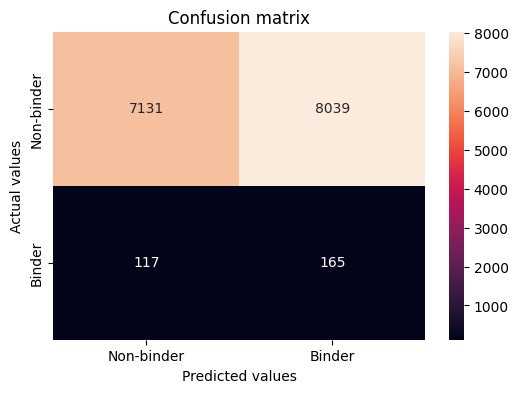

RandomForestClassifier(bootstrap=False, max_depth=20, max_features='auto',
                       n_estimators=200, n_jobs=-1, random_state=42)
Accuracy score        :  [0.47217189]
F1 score              :  [0.03888758]
AUC                   :  0.5647205196893832
Sensitivity (TPR)     :  0.5851063829787234
Specificity (TNR)     :  0.47007251153592616
classification report :
               precision    recall  f1-score   support

           0       0.98      0.47      0.64     15170
           1       0.02      0.59      0.04       282

    accuracy                           0.47     15452
   macro avg       0.50      0.53      0.34     15452
weighted avg       0.97      0.47      0.63     15452



In [144]:
model_rf = lst_tunning_models[0][1]

accuracy, metrics, fpr , tpr, auc_score, f1 = model_run(model_rf, pX_res, py_res, pX_test, py_test)

              precision    recall  f1-score   support

  Non-binder       0.98      0.70      0.81     15170
      Binder       0.02      0.40      0.05       282

    accuracy                           0.69     15452
   macro avg       0.50      0.55      0.43     15452
weighted avg       0.97      0.69      0.80     15452



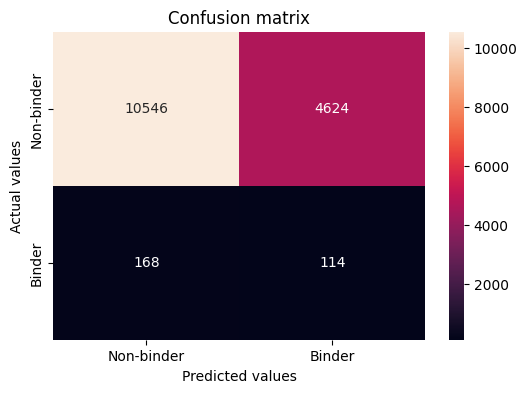

RandomForestClassifier(bootstrap=False, max_depth=70, max_features=5,
                       n_estimators=200, n_jobs=-1, random_state=42)
Accuracy score        :  [0.68987833]
F1 score              :  [0.04541833]
AUC                   :  0.573569521779174
Sensitivity (TPR)     :  0.40425531914893614
Specificity (TNR)     :  0.6951878707976269
classification report :
               precision    recall  f1-score   support

           0       0.98      0.70      0.81     15170
           1       0.02      0.40      0.05       282

    accuracy                           0.69     15452
   macro avg       0.50      0.55      0.43     15452
weighted avg       0.97      0.69      0.80     15452



In [145]:
model_rf = lst_tunning_models2[0][1]

accuracy, metrics, fpr , tpr, auc_score, f1 = model_run(model_rf, pX_res, py_res, pX_test, py_test)

### NetTCR

In [ ]:
nettcr = pd.read_csv("../../Tools/NetTCR-2.0/output/test_final.csv")
nettcr['binder_pred'] = np.where(nettcr['prediction'] >= 0.5, 1, 0)

y_test = nettcr["binder"].to_numpy()
y_test_pred = nettcr["binder_pred"].to_numpy()

confusionMatrix(y_test, y_test_pred)

tn, fp, fn, tp= confusion_matrix(y_test, y_test_pred).ravel()
accuracy = float(accuracy_score(y_test, y_test_pred).ravel())
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
auc = metrics.roc_auc_score(y_test, nettcr["prediction"])
print ("Accuracy score  : ", accuracy)
print('Sensitivity (TPR): ', sensitivity)
print('Specificity (TNR): ', specificity)
print ("AUC : ", auc)